# Motorcycle traffic collision analysis

Let's analyse California traffic collision data from SWITRS, https://www.kaggle.com/alexgude/california-traffic-collision-data-from-switrs. Out of personal interest, I focus on motorcycle data. We assume that men and women are equally likely to be involved in accidents, which allows us to look into sex differences in e.g. the favorite motorcycle brand.

Questions that we look into:
1. **What's the ratio between male and female motorcycle drivers?** I personally know a lot more male than female motorcycle drivers. Let's see whether that's just my impression.
2. **Are male drivers more likely to cause accidents than female drivers?** It's often said that female drivers are more cautious drivers and should, accordingly, be less likely to cause accidents.
3. **Do women favor different brands compared to men?** In my personal experience, women seem to favor smaller machines and motor scooters. 

## TODO

3. Nachtrag: Dear motorcycle manufacturers, produce more motorcycles that appeal to women

4. Which weather conditions are most critical for motorcycle drivers --> call to action, be careful
5. Which daytimes are most dangerous for motorcycle drivers --> call to action, be careful

In [212]:
# California Traffic Collision Data from SWITRS
# - Detailed information about every traffic collision reported to the CHP.
# https://www.kaggle.com/alexgude/california-traffic-collision-data-from-switrs

# Potential questions to answer:
# - Are motorcycle accidents seasonal? 
# - Does the weather affect the accident rate? -> less drivers drive at rain, more sunny days than rainy days ... 
# - What's the mortality rate for motorcyclists involved in (reported) accidents?

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sqlite3

from IPython.display import display, HTML
def print_df(df):
    display(HTML(df.to_html()))

In [210]:
# load data
if os.path.isfile("/kaggle/input/california-traffic-collision-data-from-switrs/switrs.sqlite"):
    con = sqlite3.connect("/kaggle/input/california-traffic-collision-data-from-switrs/switrs.sqlite")
else:
    conn = sqlite3.connect('traffic_collisions/switrs.sqlite')

sample_size = 10
if sample_size:
    df_collisions = pd.read_sql_query("SELECT * FROM collisions LIMIT {};".format(sample_size), conn)
    df_parties = pd.read_sql_query("SELECT * FROM parties LIMIT {};".format(sample_size), conn)
    df_victims = pd.read_sql_query("SELECT * FROM victims LIMIT {};".format(sample_size), conn)
    df_case_ids = pd.read_sql_query("SELECT * FROM case_ids LIMIT {};".format(sample_size), conn)
else:
    df_collisions = pd.read_sql_query("SELECT * FROM collisions;", conn)
    df_parties = pd.read_sql_query("SELECT * FROM parties;", conn)
    df_victims = pd.read_sql_query("SELECT * FROM victims;", conn)
    df_case_ids = pd.read_sql_query("SELECT * FROM case_ids;", conn)
    

In [211]:
# First look into the data
print_df(df_collisions.head(4)) # Contains information about the collision, where it happened, what vehicles were involved.
print_df(df_parties.head(4))    # Contains information about the groups people involved in the collision including age, sex, and sobriety.
print_df(df_victims.head(4))    # Contains information about the injuries of specific people involved in the collision.
print_df(df_case_ids.head(4))   # ... used to build the other tables. It tells you which of the four original datasets each row came from.

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,0081715,1941,11342,212,5,7,1941,0,0,not chp,None,not chp,003,PATTERSON ST,ATLANTIC AV,0.0,None,1.0,cloudy,None,0,None,NaN,NaN,None,None,NaN,None,None,None,1,property damage only,0,0,2,vehicle code violation,None,speeding,22350,None,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,0,None,None,NaN,NaN,1,NaN,None,None,0,0,0,0,0,0,0,0,0,None,None,None,None,2020-03-14,07:45:00,2020-06-22
1,0726202,3600,8945,064,5,5,3612,0,0,not chp,None,not chp,005,AMARGOSA,MARICOPA RD,0.0,None,NaN,clear,None,0,None,NaN,NaN,None,None,NaN,None,None,None,1,property damage only,0,0,1,vehicle code violation,None,speeding,22350,None,misdemeanor,hit object,fixed object,no pedestrian involved,dry,normal,None,dark with street lights,none,0,None,None,NaN,NaN,1,NaN,passenger car,01,0,0,0,0,0,0,0,0,0,None,None,None,None,2020-07-26,02:50:00,2020-09-30
2,3493128,9860,016616,None,2,9,3600,0,1,interstate,None,chp other,151,RT 15,LYTLE CREEK WASH,120.0,north,0.0,clear,None,1,SBD,8.0,15.0,None,None,13.10,highway,None,northbound,0,property damage only,0,0,2,vehicle code violation,None,improper turning,22107,None,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,1,None,None,NaN,1.0,1,NaN,other vehicle,47,0,0,0,0,0,0,0,0,0,None,None,None,None,2008-01-02,15:15:00,2008-08-20
3,3495044,9540,17076,None,1,9,1900,0,1,interstate,None,chp other,506,RT 5,RT 126,1000.0,south,0.0,clear,None,1,LA,7.0,5.0,None,R,55.29,highway,None,northbound,0,property damage only,0,0,2,vehicle code violation,None,speeding,22350,None,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,construction,None,daylight,none,1,None,None,NaN,1.0,1,NaN,truck or truck tractor,26,0,0,0,0,0,0,0,0,0,None,None,None,None,2008-01-02,11:30:00,2008-11-10


,id,case_id,party_number,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,cellphone_use,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,statewide_vehicle_type,chp_vehicle_type_towing,chp_vehicle_type_towed,party_race
0,1,0081715,1,driver,1,female,35.0,H,H,N,L,G,Y,None,3,None,None,None,NaN,None,N,None,0,0,proceeding straight,2007.0,FORD,None,None,None,other
1,2,0081715,2,driver,0,female,43.0,H,H,N,M,G,Y,None,3,None,None,None,NaN,None,N,None,0,0,proceeding straight,2019.0,None,None,None,None,hispanic
2,3,0726202,1,driver,1,None,NaN,G,G,N,None,None,None,None,None,None,None,None,NaN,None,N,None,0,0,proceeding straight,2005.0,None,passenger car,01,None,None
3,4,3493128,1,driver,1,None,NaN,G,G,N,None,None,None,None,3,None,None,None,NaN,None,N,None,0,0,merging,NaN,None,other vehicle,47,01,None


,id,case_id,party_number,victim_role,victim_sex,victim_age,victim_degree_of_injury,victim_seating_position,victim_safety_equipment_1,victim_safety_equipment_2,victim_ejected
0,1,3495044,2,2,male,21,no injury,3,P,G,0
1,2,3495044,2,2,male,12,no injury,2,P,C,0
2,3,3507861,2,2,male,60,no injury,9,None,None,3
3,4,3511283,1,1,female,43,other visible injury,1,M,G,0


,case_id,db_year
0,0081715,2020
1,0726202,2020
2,3493128,2020
3,3495044,2020


In [195]:
# load motorcycle and moped cases
df_motorcycles = pd.read_sql_query("SELECT at_fault, party_sex, case_id, vehicle_make, statewide_vehicle_type FROM parties WHERE statewide_vehicle_type == 'motorcycle or scooter' OR statewide_vehicle_type == 'moped';", conn)
df_motorcycles = df_motorcycles.astype({"at_fault": np.bool})

# Relation of male and female motorcycle drivers? Is a male driver more likely to cause an accident compared to a female driver?

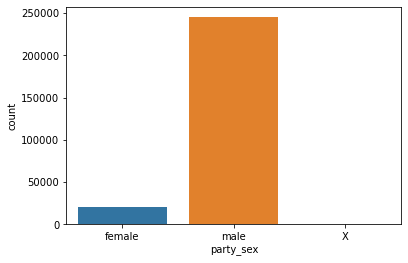

<Figure size 432x288 with 0 Axes>

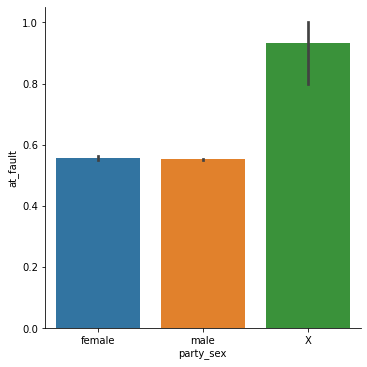

In [268]:
plt.figure()
g_sex_dist = sns.countplot(
    data=df_motorcycles,
    x="party_sex")

df_mc_c = df_motorcycles.groupby('party_sex').count()

plt.figure()
g_at_fault = sns.catplot(
    data=df_motorcycles, kind="bar",
    x="party_sex", y="at_fault")

**What's the ratio between male and female drivers?** Ratio of male vs female parties involved in motorcycle accidents: 12 to 1.

**Are male drivers more likely to cause accidents than female drivers?** There are no substantial sex differences between who is at fault.

# Motorcycle types and brands in relation to gender

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'DUCATI'),
  Text(1, 0, 'SUZUKI'),
  Text(2, 0, 'TRIUMPH'),
  Text(3, 0, 'BMW'),
  Text(4, 0, 'YAMAHA'),
  Text(5, 0, 'HARLEY-DAVIDSON'),
  Text(6, 0, 'KAWASAKI'),
  Text(7, 0, 'HONDA'),
  Text(8, 0, 'OTHER - MOPED'),
  Text(9, 0, 'VESPA')])

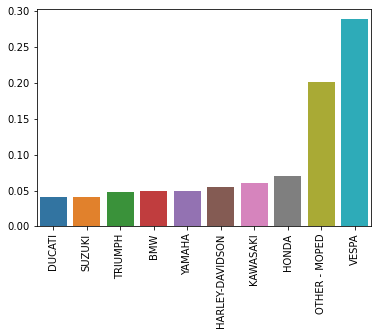

In [269]:
# Let's look into different brand statistics
df_make = df_motorcycles['vehicle_make']

# we have to clean up the data and fix a few entries
# - first problem, there are different naming schemes for the same company (e.g., HARLEY and HARLEY-DAVIDSON)
# - second problem, the list contains entries for companies that do NOT produce motorcycles. Accordingly, there seem to be car-related entries that have been flagged as motorcycle-related. This also means that we have to be careful with e.g. statistics for Honda as they produce cars and motorcylces.
make_map = {'HARLEY': 'HARLEY-DAVIDSON', 
            'HARL': 'HARLEY-DAVIDSON', 
            'HD': 'HARLEY-DAVIDSON', 
            'HOND': 'HONDA',
            'SUZI': 'SUZUKI', 
            'SUZU': 'SUZUKI', 
            'TRIU': 'TRIUMPH', 
            'KAWA': 'KAWASAKI', 
            'YAMA': 'YAMAHA', 
            'INDIAN (MOTORCYCLE)': 'INDIAN', 
            'DUCATI (MOTORCYCLE)': 'DUCATI', 
            'DUCA': 'DUCATI'}
df_make = df_make.apply(lambda x: make_map[x] if (x in make_map) else x)

# total number
df_make_counts = df_make.value_counts()
df_make_counts[df_make_counts > 100]

# number for females
df_make_sex_female = df_motorcycles[['vehicle_make', 'party_sex']]
df_make_sex_female = df_make_sex_female[df_make_sex_female['party_sex'] == 'female'].drop(columns=['party_sex'])
df_make_sex_female = df_make_sex_female['vehicle_make'].apply(lambda x: make_map[x] if (x in make_map) else x)
df_make_sex_female_counts = df_make_sex_female.value_counts()
df_make_sex_female_counts[df_make_sex_female_counts > 100]

# are there particular brands that women prefer (relative to men)?
df_j = pd.DataFrame(df_make_sex_female_counts).join(pd.DataFrame(df_make_counts), rsuffix='_total')

# let's focus on the most-frequent, valid motorcycle brands and filter entries like Dodge, ...
#make_invalid = ['TOYOTA', # to my best knowledge, they only produced concept bikes.
#              'DODGE', # same story as Toyota. While the Dodge Tomahawk is worth a look, it's just a concept
#              'FORD', # not known for motorcycles or scooters
#             '...'
#             ]
make_valid = ['BMW', 'HARLEY-DAVIDSON', 'SUZUKI', 'KAWASAKI', 'VESPA', 'DUCATI', 'TRIUMPH', 'HONDA', 'YAMAHA', 'OTHER - MOPED']
stat = pd.Series(df_j['vehicle_make'].div(df_j['vehicle_make_total']), index=make_valid).sort_values()
plt.figure()
g_make = sns.barplot(x=stat.index,y=stat)
plt.xticks(rotation=90)

**Do women favor different brands or vehicle types?** We can see that women are more likely to drive Vespas or Mopeds compared to 'traditional' motorcycles. We have to be careful with Honda in the statistics, because there seem to be errornous entries in the data.